In [1]:
import os
import math
import keras
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Conv2D, Dropout, Flatten, Dense, Activation, AveragePooling2D

In [2]:
#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Train data augmentation
train_datagen = image.ImageDataGenerator(rescale = 1/255,horizontal_flip = True,zoom_range = 0.2,
   shear_range = 0.2,rotation_range = 20,width_shift_range = 0.2,height_shift_range = 0.2,validation_split = 0.1)

train_generator = train_datagen.flow_from_directory(directory = "/content/drive/MyDrive/Dataset/SirGiven/Train",
    target_size = (64,64), batch_size = 32,class_mode = 'categorical',shuffle = True,seed = 42,subset = 'training')

val_generator = train_datagen.flow_from_directory(
    directory = "/content/drive/MyDrive/Dataset/SirGiven/Train",target_size = (64,64), batch_size = 32,class_mode = 'categorical',
    shuffle = True,seed = 42,subset = 'validation')

Found 2183 images belonging to 2 classes.
Found 242 images belonging to 2 classes.


In [4]:
#Test data augmentation
test_datagen =image.ImageDataGenerator(
   rescale =1/255)
test_data =test_datagen.flow_from_directory(directory="/content/drive/MyDrive/Dataset/SirGiven/Test",target_size= (64,64),
                                             batch_size = 32,
                                             class_mode = 'categorical')

Found 871 images belonging to 2 classes.


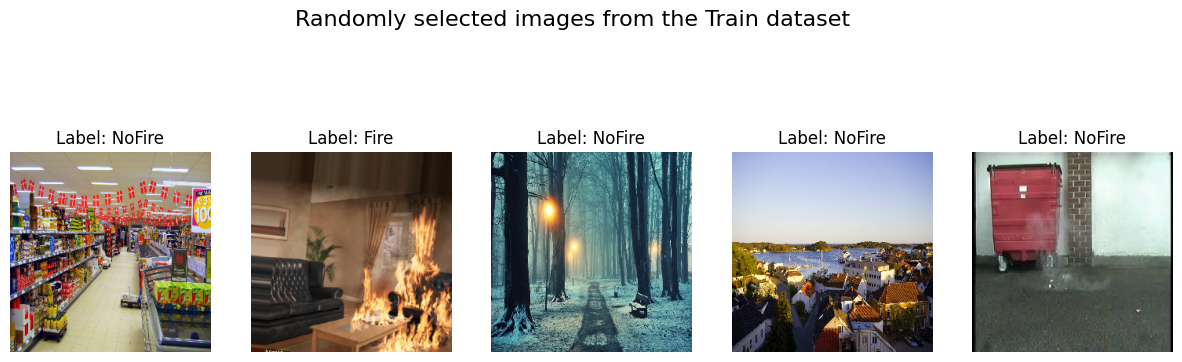

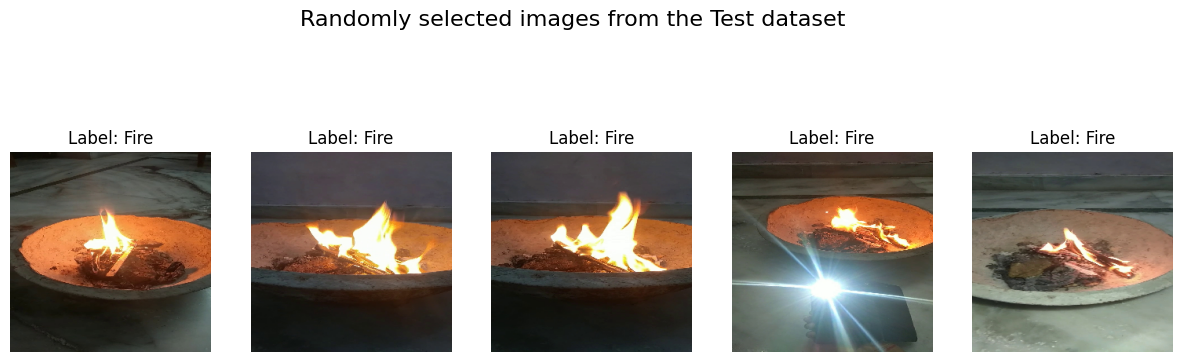

In [5]:
# Define a function to plot images and their labels
def plot_images(images, labels, title):
    fig, axs = plt.subplots(nrows=1, ncols=len(images), figsize=(15,5))
    fig.suptitle(title, fontsize=16)

    for i in range(len(images)):
        axs[i].imshow(images[i])
        axs[i].set_title('Label: ' + str(labels[i]))
        axs[i].axis('off')

    plt.show()

# Select 5 random images from the Train dataset
train_image_paths = np.random.choice(train_generator.filepaths, size=5, replace=False)
train_images = [image.load_img(path, target_size=(256,256)) for path in train_image_paths]
train_labels = [os.path.basename(os.path.dirname(path)) for path in train_image_paths]

# Select 5 random images from the Test dataset
test_image_paths = np.random.choice(test_data.filepaths, size=5, replace=False)
test_images = [image.load_img(path, target_size=(256,256)) for path in test_image_paths]
test_labels = [os.path.basename(os.path.dirname(path)) for path in test_image_paths]

# Convert images to arrays
train_images = np.array([image.img_to_array(img) for img in train_images])
test_images = np.array([image.img_to_array(img) for img in test_images])

# Rescale pixel values to range [0, 1]
train_images = train_images / 255.0
test_images = test_images / 255.0

# Plot the selected images with their labels
plot_images(train_images, train_labels, 'Randomly selected images from the Train dataset')
plot_images(test_images, test_labels, 'Randomly selected images from the Test dataset')

In [6]:
model = Sequential()

model.add(Conv2D(16, kernel_size=(3,3), activation='relu', input_shape = (64,64,3), use_bias=True))
model.add(AveragePooling2D(pool_size=(2,2)))
model.add(Dropout(rate=0.5))

model.add(Conv2D(32, kernel_size=(3,3), activation='relu', use_bias=True))
model.add(AveragePooling2D(pool_size=(2,2)))
model.add(Dropout(rate=0.5))

model.add(Conv2D(64, kernel_size=(3,3), activation='relu', use_bias=True))
model.add(AveragePooling2D(pool_size=(2,2)))
model.add(Dropout(rate=0.5))

model.add(Flatten())
model.add(Dense(256, activation= 'relu', use_bias=True))
model.add(Dropout(rate=0.2))

model.add(Dense(128, activation= 'relu', use_bias=True))
model.add(Dense(2, activation='softmax', use_bias=True))

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 31, 31, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 31, 31, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_1                  │ (None, 14, 14, 32)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_2                  │ (None, 6, 6, 64)            │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 646,818 (2.47 MB)

 Trainable params: 646,818 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
cnnModel = model.fit(train_generator,steps_per_epoch = 68, epochs = 10,
                     validation_data = val_generator,validation_steps = 8)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


68/68 ━━━━━━━━━━━━━━━━━━━━ 362s 5s/step - accuracy: 0.5976 - loss: 0.6689 - val_accuracy: 0.7066 - val_loss: 0.5934
Epoch 2/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step - accuracy: 0.7188 - loss: 0.5154
Epoch 3/10


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


68/68 ━━━━━━━━━━━━━━━━━━━━ 69s 630ms/step - accuracy: 0.7381 - loss: 0.5575 - val_accuracy: 0.7603 - val_loss: 0.5306
Epoch 4/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step - accuracy: 0.9062 - loss: 0.4171
Epoch 5/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 80s 618ms/step - accuracy: 0.7433 - loss: 0.5319 - val_accuracy: 0.7397 - val_loss: 0.5215
Epoch 6/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step - accuracy: 0.9062 - loss: 0.3247
Epoch 7/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 44s 604ms/step - accuracy: 0.7332 - loss: 0.5374 - val_accuracy: 0.7851 - val_loss: 0.4961
Epoch 8/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step - accuracy: 0.6562 - loss: 0.5847
Epoch 9/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 81s 589ms/step - accuracy: 0.7647 - loss: 0.5043 - val_accuracy: 0.6198 - val_loss: 0.6193
Epoch 10/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - accuracy: 0.4286 - loss: 1.0686


In [9]:
cnnModel = model.fit(train_generator,steps_per_epoch = 68, epochs = 20,
                     validation_data = val_generator,validation_steps = 8)

Epoch 1/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 46s 622ms/step - accuracy: 0.7424 - loss: 0.5103 - val_accuracy: 0.7190 - val_loss: 0.5405
Epoch 2/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - accuracy: 0.9062 - loss: 0.3090
Epoch 3/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 45s 617ms/step - accuracy: 0.7680 - loss: 0.4727 - val_accuracy: 0.7273 - val_loss: 0.5153
Epoch 4/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 282us/step - accuracy: 0.7500 - loss: 0.4484
Epoch 5/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 45s 617ms/step - accuracy: 0.7646 - loss: 0.4704 - val_accuracy: 0.7438 - val_loss: 0.5083
Epoch 6/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step - accuracy: 0.9062 - loss: 0.3369
Epoch 7/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 45s 612ms/step - accuracy: 0.7830 - loss: 0.4628 - val_accuracy: 0.6983 - val_loss: 0.5338
Epoch 8/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step - accuracy: 0.7188 - loss: 0.6012
Epoch 9/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 82s 619ms/step - accuracy: 0.7777 - loss: 0.4680 - val_accuracy: 0.7727 - val_loss: 0.4727
Epoch 10/20

In [10]:
cnnModel = model.fit(train_generator,steps_per_epoch = 68, epochs = 30,
                     validation_data = val_generator,validation_steps = 8)

Epoch 1/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 45s 611ms/step - accuracy: 0.8123 - loss: 0.4022 - val_accuracy: 0.8388 - val_loss: 0.3877
Epoch 2/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9375 - loss: 0.2364   
Epoch 3/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 44s 602ms/step - accuracy: 0.8296 - loss: 0.3867 - val_accuracy: 0.8678 - val_loss: 0.3519
Epoch 4/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - accuracy: 0.8125 - loss: 0.4395 
Epoch 5/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 82s 603ms/step - accuracy: 0.8178 - loss: 0.3979 - val_accuracy: 0.7727 - val_loss: 0.4358
Epoch 6/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7188 - loss: 0.5436  
Epoch 7/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 81s 590ms/step - accuracy: 0.8359 - loss: 0.3650 - val_accuracy: 0.8802 - val_loss: 0.2704
Epoch 8/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8438 - loss: 0.2471  
Epoch 9/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 47s 632ms/step - accuracy: 0.8434 - loss: 0.3642 - val_accuracy: 0.8926 - val_loss: 0.2860
Epoch 10

In [11]:
cnnModel = model.fit(train_generator,steps_per_epoch = 68, epochs = 40,
                     validation_data = val_generator,validation_steps = 8)

Epoch 1/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 46s 626ms/step - accuracy: 0.8858 - loss: 0.2716 - val_accuracy: 0.8636 - val_loss: 0.2688
Epoch 2/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step - accuracy: 0.7812 - loss: 0.4105
Epoch 3/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 81s 612ms/step - accuracy: 0.8767 - loss: 0.2929 - val_accuracy: 0.8967 - val_loss: 0.2029
Epoch 4/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step - accuracy: 0.8750 - loss: 0.2523
Epoch 5/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 45s 622ms/step - accuracy: 0.8687 - loss: 0.2977 - val_accuracy: 0.9132 - val_loss: 0.1942
Epoch 6/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step - accuracy: 0.9375 - loss: 0.1160
Epoch 7/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 44s 607ms/step - accuracy: 0.8848 - loss: 0.2748 - val_accuracy: 0.8760 - val_loss: 0.3248
Epoch 8/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step - accuracy: 0.9062 - loss: 0.3312
Epoch 9/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 82s 608ms/step - accuracy: 0.8598 - loss: 0.3334 - val_accuracy: 0.8926 - val_loss: 0.2392
Epoch 10/40

In [12]:
cnnModel = model.fit(train_generator,steps_per_epoch = 68, epochs = 50,
                     validation_data = val_generator,validation_steps = 8)

Epoch 1/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 46s 624ms/step - accuracy: 0.8752 - loss: 0.2772 - val_accuracy: 0.9339 - val_loss: 0.1413
Epoch 2/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step - accuracy: 0.8125 - loss: 0.4702
Epoch 3/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 44s 609ms/step - accuracy: 0.8858 - loss: 0.2472 - val_accuracy: 0.9174 - val_loss: 0.1946
Epoch 4/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step - accuracy: 0.9062 - loss: 0.2320
Epoch 5/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 45s 610ms/step - accuracy: 0.8972 - loss: 0.2558 - val_accuracy: 0.9091 - val_loss: 0.1858
Epoch 6/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step - accuracy: 0.8125 - loss: 0.2686
Epoch 7/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 81s 595ms/step - accuracy: 0.8986 - loss: 0.2415 - val_accuracy: 0.9298 - val_loss: 0.2240
Epoch 8/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step - accuracy: 0.9375 - loss: 0.2094
Epoch 9/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 44s 602ms/step - accuracy: 0.8898 - loss: 0.2731 - val_accuracy: 0.9256 - val_loss: 0.1783
Epoch 10/50

In [13]:
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_data, steps=math.ceil(871/32))

test_accuracy_percentage = test_acc * 100
print('Test accuracy:', test_accuracy_percentage, '%')

28/28 ━━━━━━━━━━━━━━━━━━━━ 238s 9s/step - accuracy: 0.9296 - loss: 0.1534
Test accuracy: 92.99655556678772 %


In [14]:
def print_evaluation_metrics(model, test_data):
    # Evaluate the model on the test data
    test_loss, test_acc = model.evaluate(test_data, steps=math.ceil(871/32))

    # Print the test accuracy
    test_accuracy_percentage = test_acc * 100
    print('Test accuracy:', test_accuracy_percentage, '%')

    # Make predictions on the test data
    test_predictions = model.predict(test_data, steps=math.ceil(871/32))

    # Convert the predictions from one-hot encoded format to class labels
    test_predictions_labels = np.argmax(test_predictions, axis=1)

    # Get the true class labels for the test data
    test_true_labels = test_data.classes

    # Compute the confusion matrix
    confusion_mat = confusion_matrix(test_true_labels, test_predictions_labels)
    print('Confusion Matrix:\n', confusion_mat)

    # Compute the classification report
    class_report = classification_report(test_true_labels, test_predictions_labels)
    print('Classification Report:\n', class_report)

    # Compute the precision and recall values
    tp = np.diag(confusion_mat)
    fp = np.sum(confusion_mat, axis=0) - tp
    fn = np.sum(confusion_mat, axis=1) - tp
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    print('Precision:', precision)
    print('Recall:', recall)

print('Test accuracy:', test_accuracy_percentage, '%')
print_evaluation_metrics(model, test_data)

Test accuracy: 92.99655556678772 %
28/28 ━━━━━━━━━━━━━━━━━━━━ 14s 492ms/step - accuracy: 0.9287 - loss: 0.1544
Test accuracy: 92.99655556678772 %
28/28 ━━━━━━━━━━━━━━━━━━━━ 14s 489ms/step
Confusion Matrix:
 [[396 197]
 [192  86]]
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.67      0.67       593
           1       0.30      0.31      0.31       278

    accuracy                           0.55       871
   macro avg       0.49      0.49      0.49       871
weighted avg       0.56      0.55      0.55       871

Precision: [0.67346939 0.30388693]
Recall: [0.66779089 0.30935252]


In [15]:
import os
from PIL import Image

# Define the paths to the subfolders
fire_folder = "/content/drive/MyDrive/Dataset/new/Fire"
no_fire_folder = "/content/drive/MyDrive/Dataset/new/NoFire"

# Create a list to store the predictions
predictions = []

# Loop through the fire images and get predictions
for filename in os.listdir(fire_folder):
    if filename.endswith(".jpg"):
        img = Image.open(os.path.join(fire_folder, filename))
        img = img.resize((64, 64))
        img = np.array(img) / 255
        img = np.array([img])
        prediction = model.predict(img)
        if prediction.any() > 0.5:
            predictions.append('Fire detected')
        else:
            predictions.append('No fire detected')

# Loop through the no-fire images and get predictions
for filename in os.listdir(no_fire_folder):
    if filename.endswith(".jpg"):
        img = Image.open(os.path.join(no_fire_folder, filename))
        img = img.resize((64, 64))
        img = np.array(img) / 255
        img = np.array([img])
        prediction = model.predict(img)
        if prediction.any() < 0.5:
            predictions.append('Fire detected')
        else:
            predictions.append('No fire detected')

# Print the predictions for all images
for i, prediction in enumerate(predictions):
    if i < 10:
        print(f"Fire image {i+1}: {prediction}")
    else:
        print(f"No fire image {i-9}: {prediction}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Fire image 1: Fire detected
Fire image 2: Fire detected
Fire image 3: Fire detected
Fire image 4: Fire detected
Fire image 5: Fire detected
Fire image 6: Fire detected
Fire image 7: Fire detected
Fire image 8: Fire detected
Fire image 9: No fire detected
Fire image 10: No fire detected
No fire image 1: No fire det